This notebook will be used to show how Twitter data could be used to extract overall market sentiments

## Setup - Do once (Only in Colab)

In [1]:
try:
    import google.colab
    IN_COLAB = True
    
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    os.chdir('/content/drive/My Drive/Colab Notebooks/RoboAdvisor/notebooks')
    print('Working directory changed to ' + os.getcwd())  

except:
    IN_COLAB = False




Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Working directory changed to /content/drive/My Drive/Colab Notebooks/RoboAdvisor/notebooks


In [2]:
if IN_COLAB:
    !pip install nltk
    !pip install yahoofinancials
    !pip install pytorch_pretrained_bert
    import nltk
    nltk.download('vader_lexicon')

  Created wheel for yahoofinancials: filename=yahoofinancials-1.5-cp36-none-any.whl size=15195 sha256=b54fd219ee3a5abf7543e24a0476b346258b1ba7f88673f12a18262182431212
  Stored in directory: /root/.cache/pip/wheels/42/15/e7/240c5cdc8782b9479ba73404640a3be57bb4053a5c3edd6be5
Successfully built yahoofinancials
     |████████████████████████████████| 133kB 2.7MB/s 
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## Core imports and Function definitions

In [3]:
import os
import re
from pathlib import Path
from IPython.display import HTML, display

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from yahoofinancials import YahooFinancials  # https://github.com/JECSand/yahoofinancials

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import sys
sys.path.append('..')  # add parent folder to sys path

from models.finbert.finbert import predict
from pytorch_pretrained_bert.modeling import BertForSequenceClassification

import logging
logging.disable(logging.INFO)

sia = SentimentIntensityAnalyzer()

fb_model_path = "../models/finbert/classifier_model/finbert-sentiment"
finbert = BertForSequenceClassification.from_pretrained(fb_model_path, num_labels=3, cache_dir=None)

def load_tweets(username, verbose=True):
  single_digit_hour = re.compile(r'\b(\d{1}):([0-5]?[0-9])')
  twitter_data = '../data/twitter/tweets_'+username+'.csv'
  dataset = pd.read_csv(twitter_data)

  # dataset = dataset.drop_duplicates(["permalink"])
  # dataset.to_csv(twitter_data, index=False)
  dataset = dataset.drop(['language', 'tweet_id', 'permalink', 'user_handle'], axis=1)

  # zero-pad hour in date string, then convert to a datetime
  dataset['date'] = [re.sub(single_digit_hour, lambda s: '{}:{}'.format(s.group(1).zfill(2), s.group(2)), str(x)) for x in dataset['date']]
  dataset['date'] = pd.to_datetime(dataset['date'], format="%d/%m/%Y %H:%M")

  dataset['geological_location'] = dataset['geological_location'].fillna('N/A')
  # dataset['mentions'] = dataset['mentions'].fillna('')
  # dataset['hashtags'] = dataset['hashtags'].fillna('')

  if verbose: 
    print("Tweets for " + username)
    # print(dataset.isnull().sum())
    print(dataset.info())
    print()
    print("Total rows:", len(dataset))
    display(HTML(dataset.head().to_html()))
  
  return dataset


def get_vader_sentiments(dataset):
  sentiment = []
  for tweet in dataset['text']:
      s = sia.polarity_scores(tweet)
      sentiment.append(s['compound'])

  return sentiment


def get_finbert_sentiments(dataset, username, toRun):
  output_dir = "../data/twitter"
  # output = 'sentiments_overall.csv'
  output = username+'_sentiments_overall.csv'
  output_fullpath = os.path.join(output_dir, output)

  if toRun:    
      if not os.path.exists(output_dir):
          print("Ouput directory does not exist @ " + output_dir)
      else:
          text = dataset['text'].tolist()
          results = predict(text, finbert, write_to_csv=True, path=output_fullpath)
          results.insert(0, 'date', dataset['date'])
          
          results = results.drop_duplicates(["sentence"])
          results.to_csv(output_fullpath, index=False, float_format="%.7g")
  else:
      results = pd.read_csv(output_fullpath) 
      
  dataset['finBERT'] = results['sentiment_score']

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



## Calculate Sentiments for Tweets
We will retrieve two sets of twitter data, namely from Donald Trump and CNBC

Tweets were obtained via "Twitter-Get-Old-Tweets-Scraper-master" from github (https://github.com/PJHRobles/Twitter-Get-Old-Tweets-Scraper), with some bug-fixes by arruda

In [4]:
donald = load_tweets("realDonaldTrump")
cnbc = load_tweets("cnbc")

Tweets for realDonaldTrump
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14256 entries, 0 to 14255
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   username             14256 non-null  object        
 1   date                 14256 non-null  datetime64[ns]
 2   retweets             14256 non-null  int64         
 3   favorites            14256 non-null  int64         
 4   text                 14256 non-null  object        
 5   geological_location  14256 non-null  object        
 6   mentions             4786 non-null   object        
 7   hashtags             1685 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 891.1+ KB
None

Total rows: 14256


,username,date,retweets,favorites,text,geological_location,mentions,hashtags
0,Donald J. Trump,2020-04-05 19:35:00,47790,267680,"We are learning much about the Invisible Enemy. It is tough and smart, but we are tougher and smarter!",N/A,NaN,NaN
1,Donald J. Trump,2020-04-05 16:30:00,12790,51118,Thank you Gayle! https://twitter.com/gayletrotter/status/1245824009893273600 …,N/A,NaN,NaN
2,Donald J. Trump,2020-04-05 16:26:00,8186,36426,I agree! https://twitter.com/mediabuzzfnc/status/1246817974511702018 …,N/A,NaN,NaN
3,Donald J. Trump,2020-04-05 16:25:00,8798,35756,A very biased “journalist”. https://twitter.com/MediaBuzzFNC/status/1246824052997722114 …,N/A,NaN,NaN
4,Donald J. Trump,2020-04-05 16:23:00,22021,131418,A great & wonderful woman! https://twitter.com/abc/status/1246092030603931649 …,N/A,NaN,NaN


Tweets for cnbc
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58529 entries, 0 to 58528
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   username             58529 non-null  object        
 1   date                 58529 non-null  datetime64[ns]
 2   retweets             58529 non-null  int64         
 3   favorites            58529 non-null  int64         
 4   text                 58529 non-null  object        
 5   geological_location  58529 non-null  object        
 6   mentions             11929 non-null  object        
 7   hashtags             1874 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 3.6+ MB
None

Total rows: 58529


,username,date,retweets,favorites,text,geological_location,mentions,hashtags
0,CNBC,2020-04-05 23:12:00,86,170,Top U.S. toilet paper maker: 'We're working around the clock' (via @CNBCMakeIt) https://cnb.cx/2V3k733,N/A,@CNBCMakeIt,NaN
1,CNBC,2020-04-05 22:04:00,15,43,"Sometimes, the best thing to do is nothing. And according to Duke University behavioral economist @danariely, nothing is exactly what most investors should do during the coronavirus outbreak. https://cnb.cx/2UySZJU #investinyou (In partnership with @acorns.)pic.twitter.com/VHNhFeTjSe",N/A,@danariely @acorns,#investinyou
2,CNBC,2020-04-05 14:39:00,198,483,"Bill Gates calls coronavirus pandemic a 'nightmare scenario,' but predicts lower death toll than Trump https://cnb.cx/2xRsZR4",N/A,NaN,NaN
3,CNBC,2020-04-04 15:44:00,281,1051,"China is donating 1,000 ventilators to help New York in coronavirus fight https://cnb.cx/2X8bnLv",N/A,NaN,NaN
4,CNBC,2020-04-04 14:44:00,49,149,Bank of America says the lows for stock prices and corporate bonds are in https://cnb.cx/3aUjwqM,N/A,NaN,NaN


### Perform preprocessing of tweets

In [0]:
# pat1 = r'@[A-Za-z0-9]+' # this is to remove any text with @....
# pat2 = r'^https?:\/\/.*[\r\n]*'
# # pat2 = r'https?://[A-Za-z0-9./]+'  # this is to remove the urls
# combined_pat = r'|'.join((pat1, pat2)) 
# pat3 = r'[^a-zA-Z]' # to remove every other character except a-z & A-Z
# combined_pat2 = r'|'.join((combined_pat,pat3)) # we combine pat1, pat2 and pat3 to pass it in the cleaning steps

# import re
# import nltk
# cleaned_tweets = []

# Typical preprocessing will perform lowercasing, Stemming/Lemmatization and stopwords removal 
# BUT for sentiments, letter case is important
# Stemming/lemmatization also does not seem to be required
# Stopwords should not be removed as they might change the meaning of the words/sentences
# so we will just remove mentions (@) and urls
# for i in range(0, len(dataset['text'])) :
#     tweets = re.sub(combined_pat2,' ',dataset['text'][i])
#     cleaned_tweets.append(tweets)

### Try using VADER for sentiment analysis
VADER (Valence Aware Dictionary and sEntiment Reasoner) which is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media
(read more here: https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f)

In [0]:
donald['vader'] = get_vader_sentiments(donald)
cnbc['vader'] = get_vader_sentiments(cnbc)

donald_vader_zero = donald[donald['vader']==0][['text','vader']]
cnbc_vader_zero = cnbc[cnbc['vader']==0][['text', 'vader']]
# dataset['vader'] = sentiment
# dataset[['text','vader']][:15]

In [0]:
display(HTML(donald_vader_zero[:10].to_html()))

,text,vader
6,He wants to raise taxes all over our Country! https://twitter.com/parscale/status/1246088501625487362 …,0.0
7,Disgraceful! https://twitter.com/ByronYork/status/1246276518394974209 …,0.0
14,30 DAYS TO SLOW THE SPREADpic.twitter.com/GIzwKSt5mq,0.0
23,The Paycheck Protection Program is now available! #CARESAct\n\nSmall Business Guidance &amp; Loan Resources: http://SBA.gov pic.twitter.com/eosegomf38,0.0
27,“The States have to get the money to the people who need it.” @MariaBartiromo And FAST!,0.0
28,30 DAYS TO SLOW THE SPREAD\n#COVIDー19 http://CoronaVirus.gov pic.twitter.com/RSUHRfT8If,0.0
36,Will be starting The White House news conference at 5:30 P.M. Eastern.,0.0
57,pic.twitter.com/GIzwKSbuuS,0.0
58,pic.twitter.com/C4YLj4hKZn,0.0
59,pic.twitter.com/GElcwjwBY2,0.0


In [0]:
display(HTML(cnbc_vader_zero[:10].to_html()))

,text,vader
5,"Tesla is dismissing contractors at its California and Nevada factories, sources say https://cnb.cx/3dSHF2W",0.0
6,Working from home is now mainstream. But is it here to stay? https://cnb.cx/2UTrZ72 pic.twitter.com/EQoGzyVpaa,0.0
9,"JUST IN: U.S. weekly jobless claims surge to more than 6.6 million, vs. 3.1 million expected. https://cnb.cx/2UUZ4PZ pic.twitter.com/epBko1YCOx",0.0
14,Check out these photos of the field hospital being built in New York's Central Park. https://cnb.cx/3bBS8Ov pic.twitter.com/xQ2goTnH0O,0.0
18,A barrel of oil is now cheaper than a pint of beer in Canada https://cnb.cx/2QXgTwN,0.0
20,Apple will produce 1 million face shields per week for medical workers https://cnb.cx/2V5IdKd,0.0
24,Coronavirus live updates: US cases continue to rise faster than other countries https://cnb.cx/2VeTHvl,0.0
30,"Uninsured Americans could be facing nearly $75,000 in medical bills if hospitalized for coronavirus. (via @CNBCMakeIt) https://cnb.cx/3bFtL2r",0.0
34,"Private aviation start-up @WheelsUp is going “Meals Up” to donate 10 million meals to nonprofit Feeding America, partnering with Seattle Seahawks quarterback @DangeRussWilson. https://cnb.cx/2X89ej9 pic.twitter.com/u92KQT5lwK",0.0
42,The World Health Organization has declared the coronavirus outbreak a global pandemic. But what exactly is a pandemic and what happens now? (via @CNBCi)pic.twitter.com/eMN3Q4SNtF,0.0


Vader failed to capture 'clear' negative sentiments for some of the above, and regarded them as neutral, so while it is supposed to be suitable for social media, it is unfortunately not good enough for finance related tweets.

### Try using FinBert for Sentiment Analysis
FinBERT is a pre-trained NLP model to analyze sentiment of financial text. It is built by further training the BERT language model in the finance domain, using a large financial corpus and thereby fine-tuning it for financial sentiment classification
See https://arxiv.org/pdf/1908.10063.pdf @ https://github.com/ProsusAI/finBERT

In [0]:
# Remember to set to False after first run otherwise it will take a long time to predict all predictions again!
toRun = False

get_finbert_sentiments(donald, "realDonaldTrump", toRun=toRun)
get_finbert_sentiments(cnbc, "cnbc", toRun=toRun)

In [18]:
donald_vader_zero = donald[donald['vader']==0][['text','vader', 'finBERT']]
display(HTML(donald_vader_zero[:10].to_html()))

,text,vader,finBERT
6,He wants to raise taxes all over our Country! https://twitter.com/parscale/status/1246088501625487362 …,0.0,0.126815
7,Disgraceful! https://twitter.com/ByronYork/status/1246276518394974209 …,0.0,-0.715082
14,30 DAYS TO SLOW THE SPREADpic.twitter.com/GIzwKSt5mq,0.0,-0.419386
23,The Paycheck Protection Program is now available! #CARESAct\n\nSmall Business Guidance &amp; Loan Resources: http://SBA.gov pic.twitter.com/eosegomf38,0.0,-0.001935
27,“The States have to get the money to the people who need it.” @MariaBartiromo And FAST!,0.0,0.161658
28,30 DAYS TO SLOW THE SPREAD\n#COVIDー19 http://CoronaVirus.gov pic.twitter.com/RSUHRfT8If,0.0,-0.212633
36,Will be starting The White House news conference at 5:30 P.M. Eastern.,0.0,0.017731
57,pic.twitter.com/GIzwKSbuuS,0.0,-0.002527
58,pic.twitter.com/C4YLj4hKZn,0.0,0.003932
59,pic.twitter.com/GElcwjwBY2,0.0,-0.005635


In [19]:
cnbc_vader_zero = cnbc[cnbc['vader']<0][['text','vader', 'finBERT']]
display(HTML(cnbc_vader_zero[:10].to_html()))

,text,vader,finBERT
2,"Bill Gates calls coronavirus pandemic a 'nightmare scenario,' but predicts lower death toll than Trump https://cnb.cx/2xRsZR4",-0.8462,-0.739470
4,Bank of America says the lows for stock prices and corporate bonds are in https://cnb.cx/3aUjwqM,-0.2023,-0.689633
10,European stocks just posted their worst quarter since 2002. Here's what to expect now. https://cnb.cx/39BaRIm pic.twitter.com/xKXJs79dCf,-0.6249,-0.651000
15,How the coronavirus crisis could establish China as a global leader https://cnb.cx/2Jr5ssK,-0.6249,0.452374
17,Moody's cuts outlook on $6.6 trillion US corporate debt pile to 'negative' https://cnb.cx/3avGe8K,-0.5719,-0.914406
19,"Coronavirus job losses could total 47 million, unemployment rate may hit 32%, Fed estimates https://cnb.cx/39uyR03",-0.6808,-0.899655
23,Trump says Navy captain letter asking for help on coronavirus-stricken ship 'was terrible' https://cnb.cx/2JFLkDG,-0.1027,-0.824608
26,DOT: Airlines must give refunds — not just vouchers — when flights are axed amid coronavirus https://cnb.cx/2UILY9L,-0.3182,-0.670830
28,Germany has a low coronavirus mortality rate: Here's why https://cnb.cx/2R5UTzR,-0.2732,-0.005744
29,"Worldwide coronavirus cases reach 1 million, doubling in a week as death toll tops 50,000. https://cnb.cx/2Jxx0g6 pic.twitter.com/wphGLZFIPY",-0.1280,0.247646


With FinBERT, sentiment scores seem to reflect actual sentiments better!

In [0]:
def get_daily(dataset):
  # we need to convert the sentiments to the correct timezone
  # in our case, we will be looking at the US stockmarket (NYSE). Therefore, timezone is UTC-5
  dataset["date_nyse"] = dataset["date"].dt.tz_localize('UTC').dt.tz_convert('US/Eastern').dt.tz_localize(None)

  # Average scores over the day for sentiments, and sum for retweets and favourites
  # df = dataset.resample('D', on='date').mean()
  # df[['retweets', 'favorites']] = dataset[['date','retweets', 'favorites']].resample('D', on='date').sum()

  resampled_daily = dataset.resample('D', on='date_nyse')
  df = resampled_daily.mean()  # in general, take the mean
  df['finBERT_min'] = resampled_daily['finBERT'].min() # also record the min sentiment for the day
  df['finBERT_max'] = resampled_daily['finBERT'].max() # also record the max sentiment for the day
  df[['retweets', 'favorites']] = resampled_daily[['retweets', 'favorites']].sum() 
  df['buzz'] = df['retweets'] + df['favorites']  # define buzz to be the simple sum of retweets and favorites

  # plt.hist(df['buzz'], bins=100)
  # plt.title('Distribution of Buzz')
  # plt.ylabel('No. of occurences')
  # plt.xlabel('No. of tweets')
  # plt.show()

  # assume buzz follows gaussian distribution -> standardisation to mean=0, stdev=1
  df['buzz_n'] = (df['buzz']-df['buzz'].mean())/df['buzz'].std()  

  df['sent_wn'] = df['buzz_n'] * df['finBERT']
  df['sent_wn'] = (df['sent_wn']-df['sent_wn'].min())/(df['sent_wn'].max()-df['sent_wn'].min())  # normalisation of sentiments


  # perform EMA on sentiments to smoothen noise
  df['sent12'] = df['finBERT'].ewm(span=12,adjust=False).mean() 
  df['sent26'] = df['finBERT'].ewm(span=26,adjust=False).mean()  
  df['sent50'] = df['finBERT'].ewm(span=50,adjust=False).mean()  
  df['sent200'] = df['finBERT'].ewm(span=200,adjust=False).mean()  

  return df

In [21]:
# convert sentiments to correct timezone and get daily sentiments
donald_daily = get_daily(donald)
cnbc_daily = get_daily(cnbc)

print(cnbc_daily.index[0], donald_daily.index[0])
donald_trunc = donald_daily[donald_daily.index >= cnbc_daily.index[0]]  # because CNBC data is only until 2018
cnbc_daily.head()

2018-03-12 00:00:00 2013-03-22 00:00:00


,retweets,favorites,vader,finBERT,finBERT_min,finBERT_max,buzz,buzz_n,sent_wn,sent12,sent26,sent50,sent200
date_nyse,,,,,,,,,,,,,
2018-03-12,1201,2184,0.050648,-0.041461,-0.950706,0.856566,3385,-0.406596,0.963123,-0.041461,-0.041461,-0.041461,-0.041461
2018-03-13,2985,4294,-0.023388,-0.108212,-0.901304,0.883569,7279,-0.061350,0.960816,-0.051730,-0.046405,-0.044079,-0.042125
2018-03-14,2729,4657,-0.002420,-0.075300,-0.912810,0.839234,7386,-0.051863,0.960199,-0.055356,-0.048546,-0.045303,-0.042455
2018-03-15,2758,4190,0.029451,-0.105791,-0.935617,0.899704,6948,-0.090697,0.961483,-0.063116,-0.052786,-0.047675,-0.043085
2018-03-16,2818,4099,-0.025212,-0.051798,-0.892756,0.897883,6917,-0.093445,0.960410,-0.061374,-0.052713,-0.047837,-0.043172


Retrieve stock data for overall US market (SPY) and the 'fear' index (^VIX)

High VIX readings mean investors see significant risk that the market will move sharply, whether downward or upward. The highest VIX readings occur when investors anticipate that huge moves in either direction are likely. Only when investors perceive neither significant downside risk nor significant upside potential will the VIX be low.

In [22]:
start = max(cnbc_daily.index[0], donald_daily.index[0]).strftime('%Y-%m-%d')
end = min(cnbc_daily.index[-1], donald_daily.index[-1]).strftime('%Y-%m-%d')

tickers = ['SPY', '^VIX']
yahoo_financials = YahooFinancials(tickers)
ydata = yahoo_financials.get_historical_price_data(start, end, 'daily')

spy_data = pd.DataFrame(ydata[tickers[0]]['prices']).filter(['formatted_date', 'adjclose', 'volume'])
spy_data['formatted_date'] = pd.to_datetime(spy_data['formatted_date'])
spy_data.set_index('formatted_date', inplace=True, drop=True)

vix_data = pd.DataFrame(ydata[tickers[1]]['prices']).filter(['formatted_date', 'adjclose', 'volume'])
vix_data['formatted_date'] = pd.to_datetime(vix_data['formatted_date'])
vix_data.set_index('formatted_date', inplace=True, drop=True)

# The 12- and 26-day exponential moving averages (EMAs) are often the most popularly quoted or analyzed short-term averages
spy_data['EMA12'] = spy_data['adjclose'].ewm(span=12,adjust=False).mean()
spy_data['EMA26'] = spy_data['adjclose'].ewm(span=26,adjust=False).mean()
spy_data['EMA50'] = spy_data['adjclose'].ewm(span=50,adjust=False).mean()
spy_data['EMA200'] = spy_data['adjclose'].ewm(span=200,adjust=False).mean()

print('start:', start, ', end:', end)
# print(spy_data.head())

fig = make_subplots(rows=2, cols=1, specs=[[{"secondary_y": True}], [{"secondary_y": False}]])
fig.add_trace(go.Scatter(x=spy_data.index, y=spy_data['adjclose'], opacity=0.2, name='spy'), secondary_y=False)
fig.add_trace(go.Scatter(x=vix_data.index, y=vix_data['adjclose'], opacity=0.8, name='vix'), secondary_y=True)

# fig.add_trace(go.Scatter(x=spy_data.index, y=spy_data['EMA12'], opacity=0.8, name='spy'), secondary_y=False)
fig.add_trace(go.Scatter(x=spy_data.index, y=spy_data['EMA26'], opacity=0.8, name='spy'), secondary_y=False)

# fig.add_trace(go.Scatter(x=donald_trunc.index, y=donald_daily['finBERT'], opacity=0.2, name='sent (donald)'), row=2, col=1)
fig.add_trace(go.Scatter(x=donald_trunc.index, y=donald_daily['sent26'], opacity=0.8, name='sent26 (donald)'), row=2, col=1)
# fig.add_trace(go.Scatter(x=cnbc_daily.index, y=cnbc_daily['finBERT'], opacity=0.2, name='sent (cnbc)'), row=2, col=1)
fig.add_trace(go.Scatter(x=cnbc_daily.index, y=cnbc_daily['sent26'], opacity=0.8, name='sent26 (cnbc)'), row=2, col=1)

start: 2018-03-12 , end: 2020-04-05


## Let's check for possible Synchrony between the stocks data and the tweet sentiments during volatile periods

https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9

CNBC
adjclose    0.892041
EMA12       0.790329
EMA26       0.694633
dtype: float64

Donald Trump
adjclose   -0.590289
EMA12      -0.741764
EMA26      -0.775689
dtype: float64


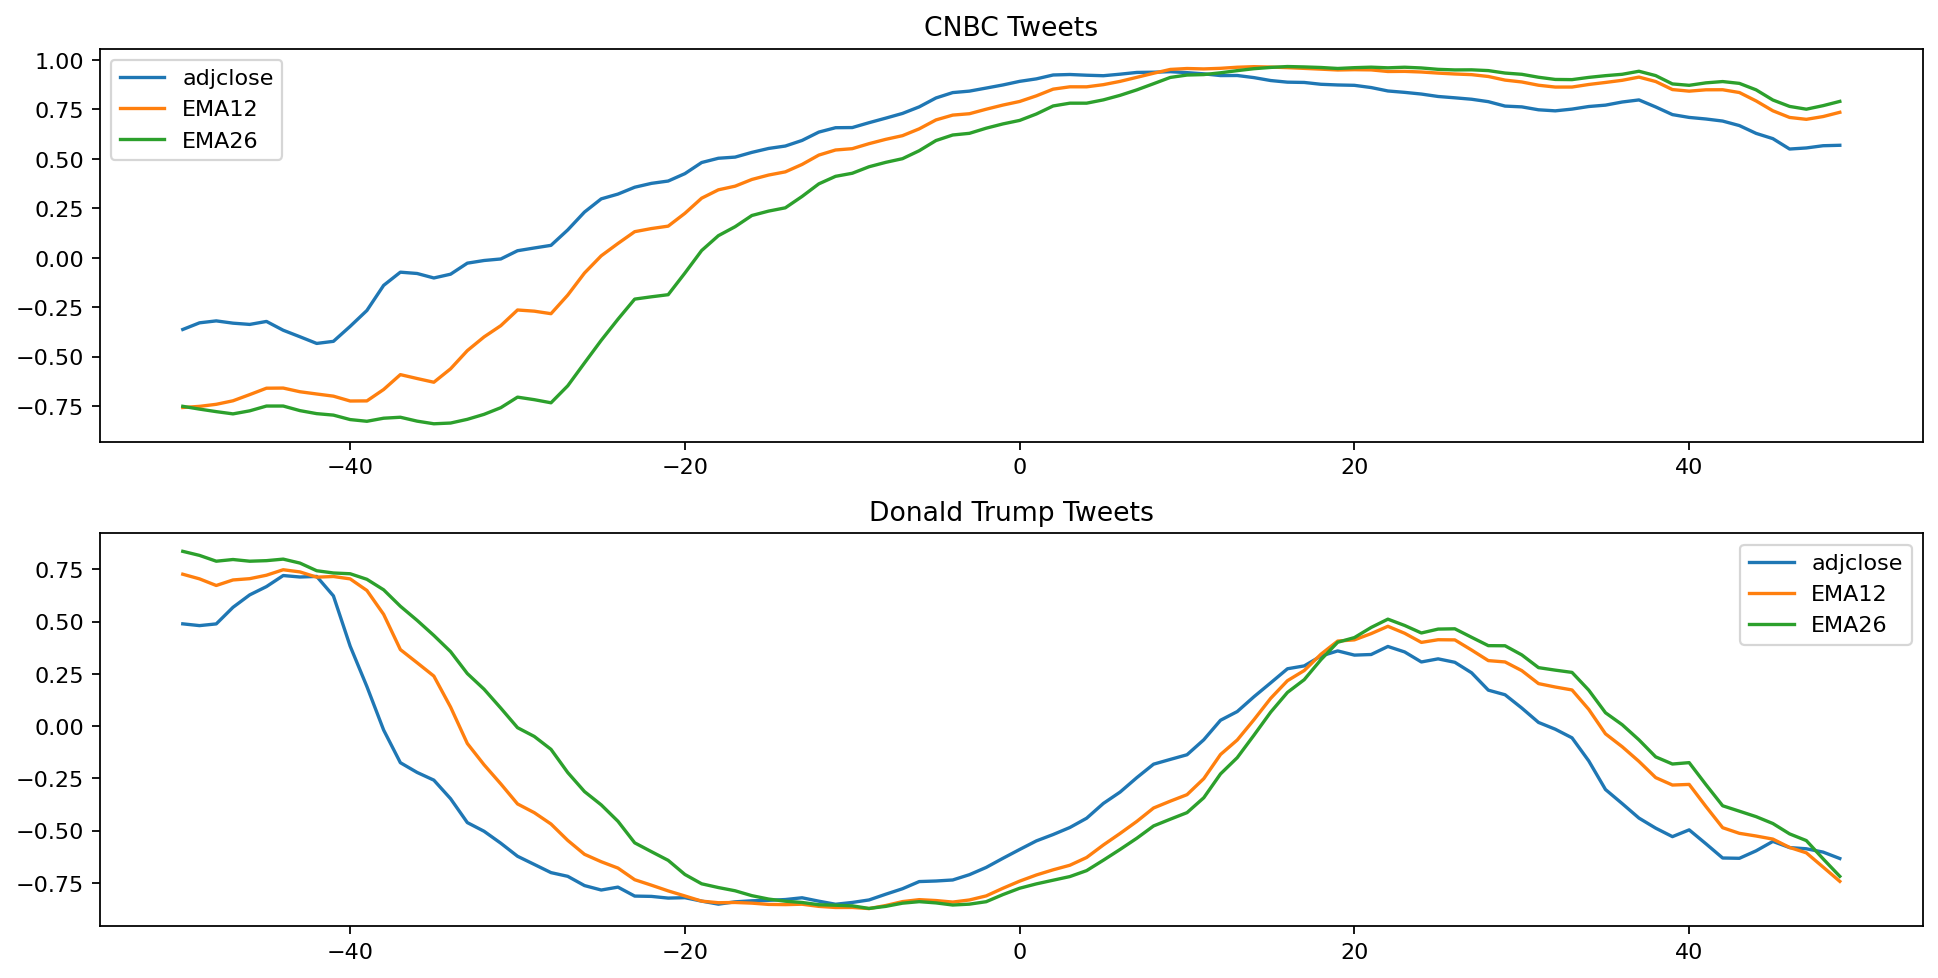

In [25]:
from datetime import datetime

# We zoom in on the period from 2020-01-01 (where the COVID19 crash begins) 
s = spy_data[spy_data.index > datetime(2020, 1, 1)]
c = cnbc_daily[cnbc_daily.index > datetime(2020, 1, 1)]
d = donald_trunc[donald_trunc.index > datetime(2020, 1, 1)]

# Try using Pearson correlation 
print('CNBC')
print(s[['adjclose', 'EMA12', 'EMA26']].corrwith(c['sent26'], axis=0))

print('\nDonald Trump')
print(s[['adjclose', 'EMA12', 'EMA26']].corrwith(d['sent26'], axis=0))

# Pearson correlation with shifting to see if correlation has time-lag/lead
corr_cnbc = []
corr_donald = []

for i in range(-50, 50):
  corr_cnbc.append(s[['adjclose', 'EMA12', 'EMA26']].corrwith(c.shift(i)['sent26'], axis=0))
  corr_donald.append(s[['adjclose', 'EMA12', 'EMA26']].corrwith(d.shift(i)['sent26'], axis=0))  

df_corr_cnbc = pd.DataFrame(corr_cnbc,index=range(-50,50))
df_corr_donald = pd.DataFrame(corr_donald, index=range(-50,50))


fig, axes = plt.subplots(nrows=2,ncols=1, constrained_layout=True, figsize=(12,6), dpi=160)
axes[0].set_title("CNBC Tweets")
axes[1].set_title("Donald Trump Tweets")
df_corr_cnbc.plot(ax=axes[0])
df_corr_donald.plot(ax=axes[1])

Sentiments of CBNC Tweets (26-day averaged) have high correlation with SPY index, with little time-lag/lead

In [0]:
df = cnbc_daily

print('len sentiments:', len(df), '\nlen stock data:', len(spy_data))
print('Length of df and spy_data are different, because trading days do not include weekends and holidays!')
# print('We will combine them, taking the union, and then fill in the missing adjclose with the last value')
print('We will combine them by taking the intersection ie only trading days')
# spy_data.info()

# We will combine them, taking the union, and then fill in the missing adjClose with the last value
# data = df.merge(spy_data, left_index=True, right_index=True, how='outer')
data = df.merge(spy_data, left_index=True, right_index=True, how='inner')
data['adjclose'] = data['adjclose'].fillna(method='ffill')
data['EMA12'] = data['EMA12'].fillna(method='ffill')
data['EMA26'] = data['EMA26'].fillna(method='ffill')
print('len combined data:', len(data))

# save as csv
# daily_fullpath = '../data/twitter/' + username + '_sentiments_overall_daily.csv'
daily_fullpath = '../data/twitter/sentiments_overall_daily.csv'
data.to_csv(daily_fullpath, index_label='date')

# print(comb_data.isnull().sum())
data[0:30]

len sentiments: 756 
len stock data: 521
Length of df and spy_data are different, because trading days do not include weekends and holidays!
We will combine them by taking the intersection ie only trading days
len combined data: 521


,retweets,favorites,vader,finBERT,finBERT_min,finBERT_max,buzz,buzz_n,sent_wn,sent12,sent26,sent50,sent200,adjclose,volume,EMA12,EMA26,EMA50,EMA200
2018-03-12,1201,2184,0.050648,-0.041461,-0.950706,0.856566,3385,-0.406596,0.963123,-0.041461,-0.041461,-0.041461,-0.041461,266.680542,71924800,266.680542,266.680542,266.680542,266.680542
2018-03-13,2985,4294,-0.023388,-0.108212,-0.901304,0.883569,7279,-0.061350,0.960816,-0.051730,-0.046405,-0.044079,-0.042125,264.957031,91968900,266.415386,266.552875,266.612953,266.663393
2018-03-14,2729,4657,-0.002420,-0.075300,-0.912810,0.839234,7386,-0.051863,0.960199,-0.055356,-0.048546,-0.045303,-0.042455,263.597351,105895100,265.981843,266.333947,266.494694,266.632885
2018-03-15,2758,4190,0.029451,-0.105791,-0.935617,0.899704,6948,-0.090697,0.961483,-0.063116,-0.052786,-0.047675,-0.043085,263.310150,83433000,265.570813,266.109962,266.369810,266.599823
2018-03-16,2818,4099,-0.025212,-0.051798,-0.892756,0.897883,6917,-0.093445,0.960410,-0.061374,-0.052713,-0.047837,-0.043172,263.595703,100343700,265.266950,265.923721,266.261022,266.569931
2018-03-19,66744,202050,-0.048395,-0.183754,-0.953422,0.738148,268794,23.124801,0.000000,-0.075473,-0.060942,-0.052696,-0.044536,260.029114,109208400,264.461129,265.487083,266.016633,266.504848
2018-03-20,3758,5274,0.045909,-0.066301,-0.944642,0.883985,9032,0.094072,0.957909,-0.074062,-0.061339,-0.053229,-0.044753,260.471405,59757300,263.847325,265.115551,265.799173,266.444814
2018-03-21,2450,3987,0.028430,-0.028179,-0.936506,0.857442,6437,-0.136003,0.960183,-0.067003,-0.058883,-0.052247,-0.044588,259.971466,78709600,263.251039,264.734508,265.570636,266.380403
2018-03-22,2434,3325,-0.002733,-0.201799,-0.938683,0.853148,5759,-0.196115,0.968252,-0.087741,-0.069469,-0.058112,-0.046152,253.472916,148785900,261.746713,263.900316,265.096215,266.251970
2018-03-23,2167,3266,-0.135547,-0.219845,-0.929488,0.796317,5433,-0.225018,0.970485,-0.108065,-0.080608,-0.064454,-0.047880,248.070251,183534800,259.642642,262.727719,264.428531,266.071057


In [0]:
fig = make_subplots(rows=2, cols=1, specs=[[{"secondary_y": True}], [{"secondary_y": False}]])
fig.add_trace(go.Scatter(x=data.index, y=data['finBERT'], opacity=0.2, name='sent'), secondary_y=True)
fig.add_trace(go.Scatter(x=data.index, y=data['sent12'], opacity=0.8, name='sent12'), secondary_y=True)
fig.add_trace(go.Scatter(x=data.index, y=data['sent26'], opacity=0.8, name='sent26'), secondary_y=True)
# fig.add_trace(go.Scatter(x=data.index, y=data['sent_min'], opacity=0.2, name='sent (min)'), secondary_y=True)
# fig.add_trace(go.Scatter(x=data.index, y=data['sent_max'], opacity=0.2, name='sent (max)'), secondary_y=True)

fig.add_trace(go.Scatter(x=data.index, y=data['adjclose'], opacity=0.2, name='SPY'), secondary_y=False)
fig.add_trace(go.Scatter(x=data.index, y=data['EMA12'], opacity=0.8, name='SPY12'), secondary_y=False)

fig.add_trace(go.Scatter(x=data.index, y=data['buzz'], opacity=0.8, name='buzz'), secondary_y=False, row=2, col=1)
# fig.add_trace(go.Scatter(x=data.index, y=data['ret12'], opacity=0.8, name='ret12'), secondary_y=False, row=2, col=1)
# fig.add_trace(go.Scatter(x=data.index, y=data["mom"], opacity=0.8, name='mom'), secondary_y=False, row=2, col=1)
# fig.add_trace(go.Scatter(x=data.index, y=data["signal"], opacity=0.8, name='signal'), secondary_y=False, row=2, col=1)

## Create machine learning models to attempt to predict market
Let's try to use N days of features and use it to predict the average direction of the market for the following day

In [0]:
SEQ_LEN = 7 # how far back do you want to go for prediction

#Define function to convert dataframe to training, validating and testing examples
def series_to_lstm(df, seq = SEQ_LEN):
    n_vars = df.shape[1]
    cols, names = list(), list()
# input sequence (t-n, ... t-1)
    for i in range(0, seq):
        cols.append(df.shift(-i))
        names += [(df.columns[j]+ str(i)) for j in range(n_vars)]
       # print (df.head(5))
        # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    return agg

# Simple momentum calculation  
def get_mom(x, n1, n2):  
    if x[n1] > 0 and x[n2] > 0:
        return 1
    else:
        return 0

338 183


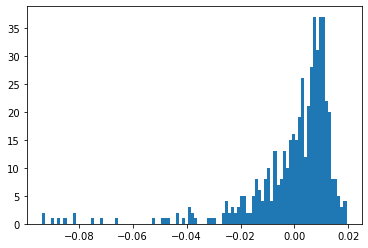

In [0]:
# Calculate returns based on EMA12's prices
data["ret12"] = data['EMA12'].pct_change(5)  # percent change over 5 days
data["ret12_lag1"] = data["ret12"].shift(1)
ret12_mean = data["ret12"].mean()
ret12_std = data["ret12"].std()

plt.hist(data['ret12'], bins=100)

# Calculate momentum
data["mom"] = data[['ret12', 'ret12_lag1']].apply(lambda x: get_mom(x, 'ret12', 'ret12_lag1'), axis=1)

# Calculate trading signal
# data["ret12_h"] = -data["ret12"].pct_change(-1)  # 1 day ahead
# data["signal"] = data["ret12_h"].apply(lambda x : 1 if x > 0 else 0 )
# data["signal"] = data["ret12_h"].apply(lambda x : 1 if x > 0 else 0 )

# Our prediction will be the next "num_days"'s returns. If it is positive relative to the day before, then we denote as 1, else 0
num_days = 5

# data["signal"] = data["ret12"].shift(-1).fillna(0).apply(lambda x : 1 if x > 0 else 0 )
# data["signal"] = (data["ret12"] - ret12_mean) / ret12_std  # normalise mean=0, std=1
# data["signal"] = data["signal"].shift(-num_days).fillna(0).apply(lambda x : 1 if x > 0 else 0 )
data["signal"] = -data['EMA12'].pct_change(-num_days)
data["signal"] = data["signal"].apply(lambda x : 1 if x > 0 else 0)



print(data[data["signal"]==1]["signal"].count(), data[data["signal"]==0]["signal"].count())


### Sentiment-enhanced LSTM Model

In [0]:
import os
import sys
sys.path.append('../models/lstm_nn')  # add parent folder to sys path
if 'lstm_nn' not in os.getcwd(): os.chdir('../models/lstm_nn')

import json
import math
import matplotlib.pyplot as plt
from core.data_processor import DataLoader
from core.model import Model

toTrain = True

# get LSTM configuration details from config.json
configs = json.load(open('config.json', 'r'))
if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

# configs['data']['filename'] = 'LiveSquawk_sentiments_overall_daily.csv'
# configs['data']['columns'] = ['EMA12', 'sent', 'sent_min', 'volume']
configs['data']['filename'] = 'cnbc_sentiments_overall_daily.csv'
configs['data']['columns'] = ['EMA12', 'sent12', 'buzz', 'volume']
configs['data']['sequence_length'] = 14
configs['model']['layers'][0]['input_timesteps'] = configs['data']['sequence_length'] - 1
configs['model']['layers'][0]['input_dim'] = len(configs['data']['columns'])

configs['training']['epochs'] = 4
    
    
data = DataLoader(
    os.path.join('data', configs['data']['filename']),
    configs['data']['train_test_split'],
    configs['data']['columns']
)

# train model
if toTrain:
    import numpy as np
    import tensorflow as tf
    np.random.seed(10)
    tf.compat.v1.set_random_seed(1)
    
    model = Model()
    model.build_model(configs)
    x, y = data.get_train_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )

    '''
    # in-memory training
    model.train(
        x,
        y,
        epochs = configs['training']['epochs'],
        batch_size = configs['training']['batch_size'],
        save_dir = configs['model']['save_dir']
    )
    '''
    # out-of memory generative training
    steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
    model.train_generator(
        data_gen=data.generate_train_batch(
            seq_len=configs['data']['sequence_length'],
            batch_size=configs['training']['batch_size'],
            normalise=configs['data']['normalise']
        ),
        epochs=configs['training']['epochs'],
        batch_size=configs['training']['batch_size'],
        steps_per_epoch=steps_per_epoch,
        save_dir=configs['model']['save_dir']
    )
    
    model_use = model

else:
    # Get predictions
    import glob
    list_of_files = glob.glob(configs['model']['save_dir'] + '/*h5') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)

    model_use = Model()
    model_use.load_model(latest_file)    

    
x_test, y_test = data.get_test_data(
    seq_len=configs['data']['sequence_length'],
    normalise=configs['data']['normalise']
)
    

[Model] Model Compiled
Time taken: 0:00:00.668003
[Model] Training Started
[Model] 4 epochs, 32 batch size, 14 batches per epoch
Epoch 1/4
14/14 [==============================] - 5s 356ms/step - loss: 0.0025
Epoch 2/4
14/14 [==============================] - 1s 54ms/step - loss: 0.0013
Epoch 3/4
14/14 [==============================] - 1s 48ms/step - loss: 9.0244e-04
Epoch 4/4
14/14 [==============================] - 1s 61ms/step - loss: 7.2196e-04
[Model] Training Completed. Model saved as saved_models\06042020-170525-e4.h5
Time taken: 0:00:07.263966


[Model] Predicting Point-by-Point...


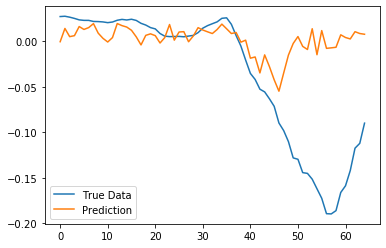

[Model] Predicting Sequences Multiple...


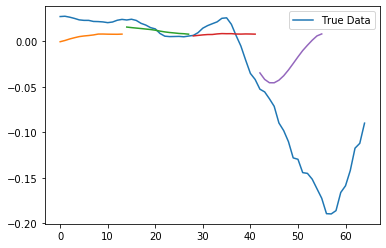

In [0]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.legend()
    # Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
    #plt.ylim(top=5, bottom=-5)    
    plt.show()
    
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()    

predictions = model_use.predict_point_by_point(x_test)
plot_results(predictions, y_test)
    
predictions_seq = model_use.predict_sequences_multiple(x_test, configs['data']['sequence_length'], configs['data']['sequence_length'])
plot_results_multiple(predictions_seq, y_test, configs['data']['sequence_length'])

In [0]:
x_test[0:10]

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 2.10606106e-03, -7.75394698e-01, -1.27642852e-01,
          8.04065575e-01],
        [ 3.98155886e-03, -1.48475449e+00,  1.07043936e+00,
          5.25458973e-01],
        [ 6.64053970e-03, -1.72586911e+00, -6.11805392e-02,
          5.48775854e-01],
        [ 8.92488207e-03, -9.56922947e-01,  1.13117975e-01,
          1.43528527e-01],
        [ 1.08676172e-02, -8.30166151e-01, -1.92564647e+00,
         -9.91238857e-02],
        [ 1.31556718e-02, -7.92755956e-01,  5.60748251e-01,
          5.96704792e-01],
        [ 1.57835681e-02, -7.04187725e-01, -1.39086693e-01,
          1.75396928e+00],
        [ 1.82493287e-02, -5.45187513e-01, -7.94466714e-01,
         -8.21836789e-03],
        [ 2.03406868e-02, -9.83535842e-01,  1.12105635e+00,
         -6.20618726e-01],
        [ 2.29553326e-02, -6.43863066e-01,  2.02908119e-01,
         -4.21453852e-01],
        [ 2.51281775e-02, -1.86568618e-01, 